In [81]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

from pymatgen.phonon.plotter import PhononDosPlotter
from pymatgen.ext.matproj import MPRester
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go



In [82]:
mp_key = "jBtrGioeefhRZ0bpN5xCDp8bQrH6O0HK"
mp_id = "mp-30459"

# Téléchargement densité états phonon pour ScNiBi

In [83]:
with MPRester(mp_key) as m:
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
    prim_struc = m.get_structure_by_material_id(mp_id)

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [84]:
fig_ph_dos = get_plot_dos(ph_dos)
fig_ph_dos.show()


# Calculs températures telles que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique.

In [85]:
#données notebook equivalente aux données excel utilisées pour le devoir8
temperatures = np.arange(5, 1000, 5)
R = 8.314
nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))]) / (3 * nat * R)

## Einstein
Valeur théorique chaleur spécifique : 
\begin{equation}
    \frac{C_v}{3.N_a.R} = (\frac{T_e}{T})^2 . \frac{e^(\frac{T_e}{T})}{(e^(\frac{T_e}{T}-1)^2}
\end{equation}

In [86]:
#code repris du devoir8 et adapté à la tache9
def theoretical_Cv_Einstein(Te, T):
    return ((Te/T)**2 * np.exp(Te/T)) / ((np.exp(Te/T) - 1)**2)

def error_func(Te, temps, cv_exp):
    cv_theo = theoretical_Cv_Einstein(Te, temps)
    return np.sum((cv_theo - cv_exp)**2)

temperatures = np.array(temperatures)
cv_experimental = np.array(ph_cv)

Te_initial_guess = 100
result = minimize(error_func, Te_initial_guess, args=(temperatures, cv_experimental))
Te_optimal = result.x[0]

print("La valeur optimale de Te qui minimise l'erreur au carré est :", Te_optimal,"K")

cv_theoretical_einstein = theoretical_Cv_Einstein(Te_optimal, temperatures)

La valeur optimale de Te qui minimise l'erreur au carré est : 227.77724172174987 K


## Debye
Valeur théorique chaleur spécifique :
\begin{equation}
    \frac{C_v}{3N_aR} = 3\left(\left(\frac{T}{T_d}\right)^3 \cdot \int_{0}^{\frac{T_d}{T}} \frac{x^4 \cdot \exp(x)}{\left(\exp(x)-1\right)^2} \, dx\right)
\end{equation}

In [87]:
#code repris du devoir8 et adapté à la tache9
def theoretical_Cv_Debye(Td, T_exp):
    def integrand(x):
        return (x**4 * np.exp(x)) / ((np.exp(x)-1)**2)
    
    result = 3 * ((T_exp / Td)**3) * quad(integrand, 0, Td / T_exp)[0]
    return result

def squared_error_Debye(Td, temps_exp, cv_exp):
    squared_errors = [(theoretical_Cv_Debye(Td, temps_exp[i]) - cv_exp[i])**2 for i in range(len(temps_exp))]
    return sum(squared_errors)

Td_initial_guess = 10 #on prend une temperature de depart faible pour debye
result = minimize(squared_error_Debye, Td_initial_guess, args=(temperatures, ph_cv))
Td_optimal = result.x[0]

print("La valeur optimale de Td qui minimise l'erreur au carré est :", Td_optimal,"K")

cv_theoretical_Debye = np.array([theoretical_Cv_Debye(Td_optimal, temp) for temp in temperatures])

La valeur optimale de Td qui minimise l'erreur au carré est : 308.00534240403476 K


## Plot chaleur spécifique en fonction de la température

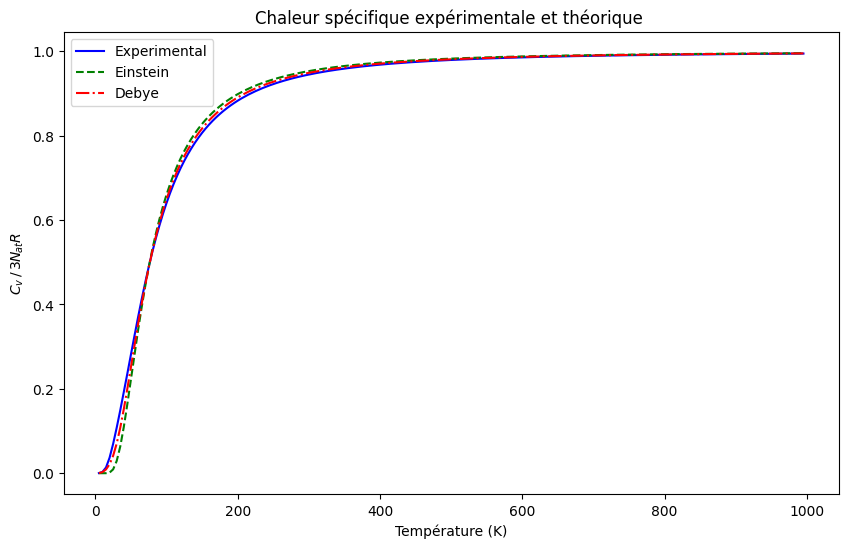

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, ph_cv, label='Experimental', color='blue')
plt.plot(temperatures, cv_theoretical_einstein, label='Einstein', linestyle='--', color='green')
plt.plot(temperatures, cv_theoretical_Debye, label='Debye', linestyle='-.', color='red')

plt.xlabel('Température (K)')
plt.ylabel('$C_v\,/\,3N_{\!at}R$')
plt.title('Chaleur spécifique expérimentale et théorique ')
plt.legend()
plt.show()


# Densités d'états phononiques correspondantes

Dans le modèle d’Einstein, la densité d'etats est un delta de Dirac piqué sur la fréquence d'Einstein.

Dans le modèle de Debye, la densité d'états est une fonction parabolique en fonction de la fréquence, celle-ci atteint son pic pour la fréquence de Debye et au dela de cette fréquence elle est nulle. La fonction présente sur les slides stipule que la densité d'états : $$g_D(w) = \left\{
    \begin{array}{ll}
        \text{$\frac{3 N_{at} \Omega w^2}{2 \pi^2 v^3}$} & \text{si } w < w_D = v.q_D \\
        \text{0} & \text{si } w > w_D
    \end{array}
\right.
$$

Il est possible de simplifier cette expression pour exprimer la densité d'états en fonction des fréquences. Pour cela nous allons remplacer les variables suivantes associées à la vitesse du son au sein de notre materiau et au rayon de la sphere contenant les vecteurs q permis respectivement dans notre équation de base: $$v = \frac{w_D}{q_D} $$ et $$q_D = (\frac{6 \pi^2}{\Omega})^{1/3}$$
Cela nous donne aprés simplifications que 
$$g_D(f) = \left\{
    \begin{array}{ll}
        \text{$\frac{9 N_{at} f^2}{2 \pi f_{d}^3}$} & \text{si } f < f_D \\
        \text{0} & \text{si } f > f_D
    \end{array}
\right.
$$

Les fréquences d'Einstein et de Debye sont calculées à partir de leurs températures respectives à l'aide de la formule donnée dans les slides : $$ f_{EouD} = \frac{T_{EouD} k_b . 10^{-12}}{h} \text{(THz)}$$  

La fréquence d'Einstein est de  4.746105980674174 THz et la fréquence de Debye est de  6.417787776397505 THz.


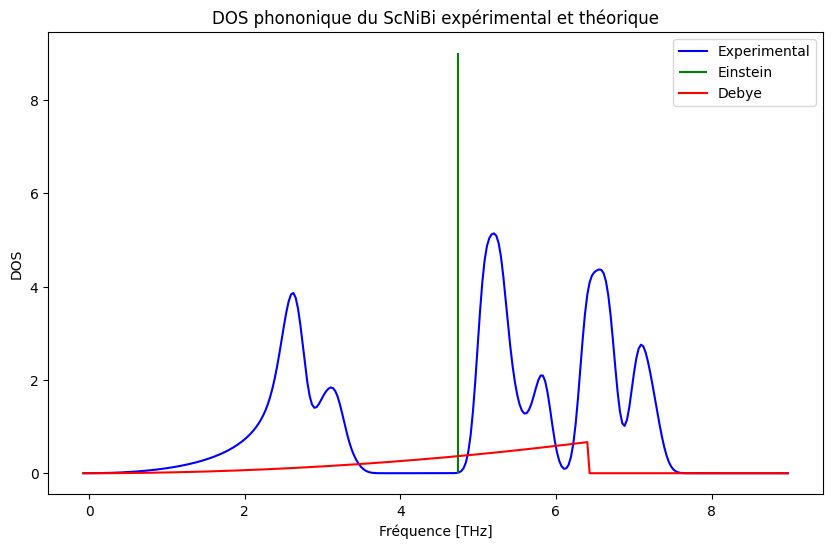

In [89]:
kb = 1.38064852e-23 #J/K boltzmann
h = 6.62607015e-34 #Js cst de planck
f = ph_dos.frequencies
dos = ph_dos.densities

#calculs freq einstein et debye en THz
f_E = (Te_optimal * kb)*10**(-12)/h 
f_D = (Td_optimal * kb)*10**(-12)/h
print("La fréquence d'Einstein est de ",f_E,"THz et la fréquence de Debye est de ",f_D,"THz.")

# il faut slmt calculer la dos de Debye car c'est une fonction augmentant de manière parabolique jusqu'a la frequence de debye, la fonction est donnée dans les slides
g_D = np.zeros(len(f))
for i in range(len(f)):
    if f[i]<f_D:
        #on part de l'equation donnée dans les slides et l'on remplace v = w_D/qd et w = 2pi.f dans les equations pour obtenir cette formule
        g_D[i] = (9*nat*(f[i])**2)/((2*np.pi)*(f_D)**3)
plt.figure(figsize=(10, 6))
plt.plot(f, dos,color='b', label="Experimental")
plt.vlines(f_E,0,3*nat, color='g', label="Einstein")
plt.plot(f, g_D, color="r", label="Debye")
plt.xlabel('Fréquence [THz]')
plt.ylabel('DOS')
plt.title("DOS phononique du ScNiBi expérimental et théorique")
plt.legend()
plt.show()

# Discussion
Les résultats montrent que les modèles de Debye et d'Einstein ajustent raisonnablement bien les données expérimentales,surtout pour de hautes températures (loi de Dulong et Petit). Cependant, des différences significatives peuvent être observées, notamment dans les régions de basse température où les effets de quantification deviennent importants. 


La densité d'états de phonons a une influence sur la chaleur spécifique expérimentale, ce qui diminue la précision des modèles qui tentent de l'approximer. Le modèle d'Einstein considère qu'il existe uniquement une seule fréquence globale pour toutes les températures tandis que le modèle de Debye considère que la densité d'états des phonons augmente paraboliquement jusqu'à une certaine fréquence (ce modèle fait l'hypothèse que toutes les fréquences ont la même dispersion linéaire). Nous observons bien visuellement dans ce cas que la densité d'états phononique réelle est très différente des densités d'états phononiques théoriques. Nos résultats ne correpondent pas à ce que l'on devrait avoir. En effet, l'aire sous la courbe théorique doit être égale à l'aire sous la densité d'état expérimentale, ce qui n'est pas le cas ici. Cela peut s'expliquer par une erreur que je n'arrive pas à identifier ou par une mauvaise détermination du rayon $q_D$ de la sphere contenant les vecteurs d'ondes permis . Malgré cela, les résultats pour les chaleurs spécifiques restent acceptables.
